Importing the Libraries

In [252]:
import pandas as pd
import numpy as np

import sklearn
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from vecstack import stacking
import pprint


from sklearn.model_selection import KFold


Reading the train csv into dataframe

In [253]:
data = pd.read_csv('Train.csv')

### Exploratory Data Analysis

Let's explore the data and get a basic intuition about it. First step is to check the top 5 and last 5 rows of the data to identify any discontinuity.

In [254]:
data.head()

,id,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
0,19717,Married-spouse-absent,Auto,Comedy,Male,45,Primetime,United-States,0.027465,High,No,False
1,31593,Married-civ-spouse,Pharma,Comedy,Male,45,Primetime,United-States,0.027465,Low,No,False
2,5681,Divorced,Entertainment,Comedy,Female,45,Primetime,United-States,0.027465,High,Yes,False
3,15491,Separated,Political,Infomercial,Female,40,Primetime,United-States,0.027465,Low,No,False
4,23587,Married-civ-spouse,Pharma,Comedy,Male,48,Primetime,United-States,0.027465,High,No,True


In [255]:
data.tail()

,id,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
26043,16009,Married-civ-spouse,Pharma,Comedy,Male,50,Primetime,United-States,0.027465,Low,No,True
26044,17241,Never-married,Auto,Comedy,Female,40,Morning,United-States,0.027465,Low,No,False
26045,2295,Married-civ-spouse,Other,Comedy,Female,25,Primetime,United-States,0.102234,Low,No,True
26046,17902,Never-married,Auto,Comedy,Female,48,Morning,United-States,0.027465,Low,Yes,False
26047,30877,Married-civ-spouse,Pharma,Infomercial,Male,40,Primetime,United-States,0.027465,Low,Yes,False


In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 12 columns):
id                                   26048 non-null int64
realtionship_status                  26048 non-null object
industry                             26048 non-null object
genre                                26048 non-null object
targeted_sex                         26048 non-null object
average_runtime(minutes_per_week)    26048 non-null int64
airtime                              26048 non-null object
airlocation                          26048 non-null object
ratings                              26048 non-null float64
expensive                            26048 non-null object
money_back_guarantee                 26048 non-null object
netgain                              26048 non-null bool
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 2.2+ MB


There are no null values in the data. We Will be working with 26048 rows and 12 columns.

In [257]:
data.describe()

,id,average_runtime(minutes_per_week),ratings
count,26048.000000,26048.000000,26048.000000
mean,16268.744779,40.294111,0.038716
std,9413.578020,12.479457,0.075852
min,2.000000,1.000000,0.000000
25%,8095.750000,40.000000,0.027465
50%,16237.000000,40.000000,0.027465
75%,24413.500000,45.000000,0.027465
max,32561.000000,99.000000,1.000000


In [258]:
data.columns

Index(['id', 'realtionship_status', 'industry', 'genre', 'targeted_sex',
       'average_runtime(minutes_per_week)', 'airtime', 'airlocation',
       'ratings', 'expensive', 'money_back_guarantee', 'netgain'],
      dtype='object')

Most of the predictor columns are categorical. Let's see the number of unique categories for these variables. 

In [259]:
data['airlocation'].unique()

array(['United-States', 'Outlying-US(Guam-USVI-etc)', 'Mexico', 'Laos',
       'International', 'India', 'Poland', 'South', 'Italy',
       'Philippines', 'Guatemala', 'Columbia', 'Taiwan', 'England',
       'Canada', 'Germany', 'Thailand', 'Puerto-Rico', 'Nicaragua',
       'Cuba', 'Trinadad&Tobago', 'Yugoslavia', 'El-Salvador', 'Peru',
       'China', 'Japan', 'Vietnam', 'Hong', 'Dominican-Republic',
       'Honduras', 'Hungary', 'Jamaica', 'France', 'Portugal', 'Ireland',
       'Ecuador', 'Iran', 'Scotland', 'Greece', 'Cambodia', 'Haiti',
       'Holand-Netherlands'], dtype=object)

In [260]:
data['realtionship_status'].unique()

array(['Married-spouse-absent', 'Married-civ-spouse', 'Divorced',
       'Separated', 'Never-married', 'Widowed', 'Married-AF-spouse'],
      dtype=object)

In [261]:
data['industry'].unique()

array(['Auto', 'Pharma', 'Entertainment', 'Political', 'ClassAction',
       'Other'], dtype=object)

In [262]:
data.groupby('industry')['ratings'].min()

industry
Auto             0.000000
ClassAction      0.002577
Entertainment    0.000000
Other            0.000000
Pharma           0.002149
Political        0.002577
Name: ratings, dtype: float64

In [263]:
data.groupby('industry')['netgain'].mean()

industry
Auto             0.100573
ClassAction      0.051508
Entertainment    0.067631
Other            0.447862
Pharma           0.444821
Political        0.021674
Name: netgain, dtype: float64

In [264]:
data[data['industry']=='Auto']

,id,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
0,19717,Married-spouse-absent,Auto,Comedy,Male,45,Primetime,United-States,0.027465,High,No,False
5,28523,Divorced,Auto,Comedy,Female,40,Primetime,United-States,0.027465,Low,Yes,False
11,23314,Never-married,Auto,Comedy,Female,25,Morning,United-States,0.027465,Low,No,False
27,5834,Divorced,Auto,Comedy,Female,50,Morning,United-States,0.027465,Low,Yes,True
32,22903,Divorced,Auto,Infomercial,Male,40,Primetime,United-States,0.027465,High,Yes,False
33,24194,Widowed,Auto,Comedy,Male,6,Daytime,United-States,0.027465,Low,Yes,False
34,23935,Widowed,Auto,Comedy,Female,35,Primetime,United-States,0.027465,Low,No,False
35,17767,Never-married,Auto,Comedy,Female,40,Morning,United-States,0.027465,High,No,False
36,19471,Never-married,Auto,Comedy,Male,40,Morning,United-States,0.027465,High,No,False
38,13444,Widowed,Auto,Comedy,Female,60,Primetime,United-States,0.027465,High,Yes,False


In [265]:
data['genre'].unique()

array(['Comedy', 'Infomercial', 'Drama', 'Direct', 'Other'], dtype=object)

In [266]:
data['targeted_sex'].unique()

array(['Male', 'Female'], dtype=object)

In [267]:
data['airtime'].unique()

array(['Primetime', 'Morning', 'Daytime'], dtype=object)

In [268]:

data['expensive'].unique()

array(['High', 'Low', 'Medium'], dtype=object)

In [269]:
data['money_back_guarantee'].unique()

array(['No', 'Yes'], dtype=object)

In [270]:
data['netgain'].unique()

array([False,  True])

In [271]:
data.columns

Index(['id', 'realtionship_status', 'industry', 'genre', 'targeted_sex',
       'average_runtime(minutes_per_week)', 'airtime', 'airlocation',
       'ratings', 'expensive', 'money_back_guarantee', 'netgain'],
      dtype='object')

Rename the columns for our convinience.

In [272]:
data = data.rename(columns={"realtionship_status": "rs", "targeted_sex": "sex",'average_runtime(minutes_per_week)':'avg_runt','money_back_guarantee':'moneyback'})

In [273]:
data.head()

,id,rs,industry,genre,sex,avg_runt,airtime,airlocation,ratings,expensive,moneyback,netgain
0,19717,Married-spouse-absent,Auto,Comedy,Male,45,Primetime,United-States,0.027465,High,No,False
1,31593,Married-civ-spouse,Pharma,Comedy,Male,45,Primetime,United-States,0.027465,Low,No,False
2,5681,Divorced,Entertainment,Comedy,Female,45,Primetime,United-States,0.027465,High,Yes,False
3,15491,Separated,Political,Infomercial,Female,40,Primetime,United-States,0.027465,Low,No,False
4,23587,Married-civ-spouse,Pharma,Comedy,Male,48,Primetime,United-States,0.027465,High,No,True


### Visualizing the data

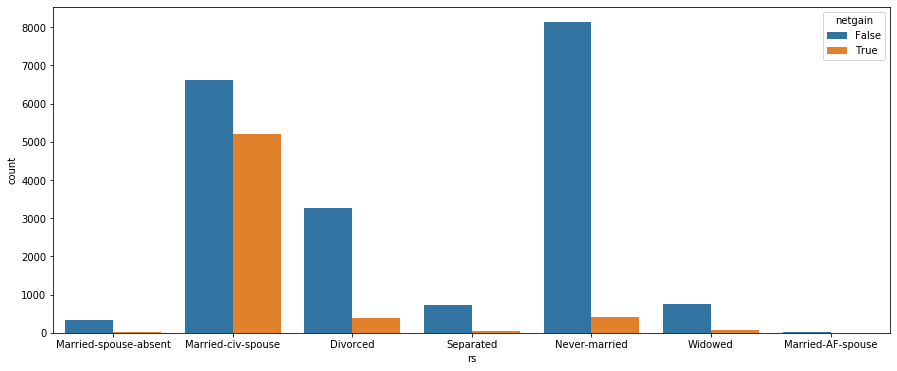

In [274]:
f = plt.figure(figsize=(15,6))
sns.countplot(x='rs',hue='netgain',data=data)

As we can see most of the targeted customers are either Married-civ-spouse or Never-Married and there is a difference in ratio of netgain for these two categories. Let's reduce the number of categories for relationship status to Married and Not-Married as other categories are not contributing significantly. Keeping them will make the data sparse after performing categorical encoding.

In [275]:
data['rs'].unique()

array(['Married-spouse-absent', 'Married-civ-spouse', 'Divorced',
       'Separated', 'Never-married', 'Widowed', 'Married-AF-spouse'],
      dtype=object)

Mapping the relationship status to "Married" for anything starting with "Married%" and mapping the rest to "Others"

In [279]:
data['rs1']=data['rs'].map({'Married-spouse-absent':'Married', 'Married-civ-spouse':'Married', 'Divorced':'Other',
       'Separated':'Other', 'Never-married':'Other', 'Widowed':'Other', 'Married-AF-spouse':'Married'})

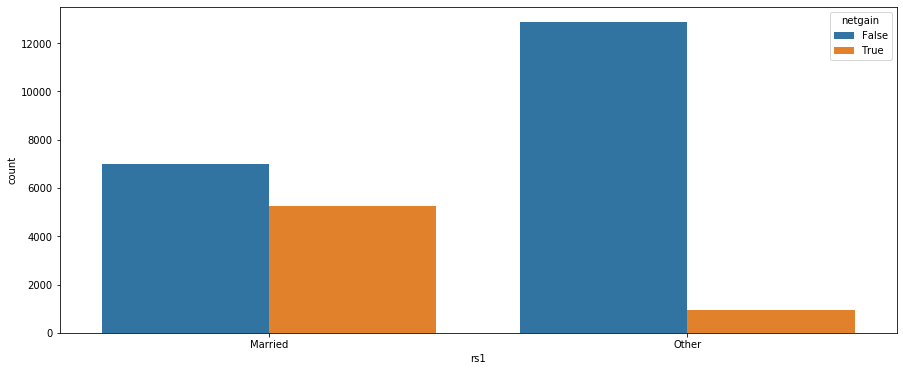

In [280]:
f = plt.figure(figsize=(15,6))
sns.countplot(x='rs1',hue='netgain',data=data)

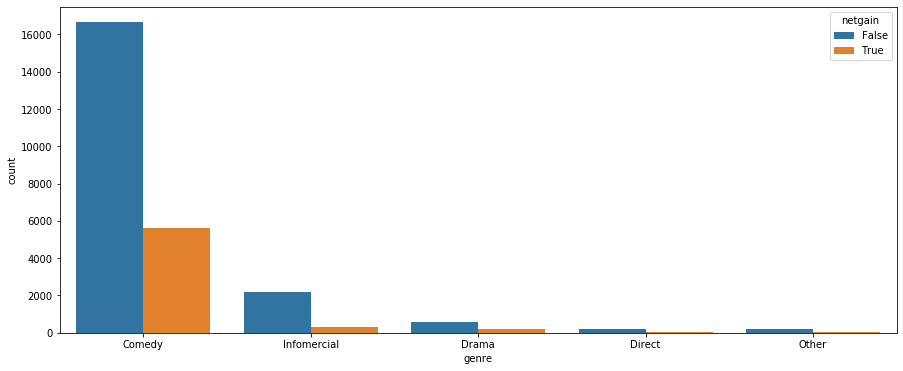

In [281]:
f = plt.figure(figsize=(15,6))
sns.countplot(x='genre',hue='netgain',data=data)

Let's club Genre other than Comedy to 'Others' as the distribution across other genre is not significant enough.

In [282]:
data.groupby('genre')['netgain'].mean()

genre
Comedy         0.251730
Direct         0.161943
Drama          0.256538
Infomercial    0.122814
Other          0.165179
Name: netgain, dtype: float64

Mapping Genre to top 3 common genre : Drama, Comedy, Infomerical

In [285]:
data['genre1'] = data['genre'].map({'Direct':'Other','Drama':'Other','Comedy':'Comedy','Infomerical':'Infomerical','Other':'Other'})

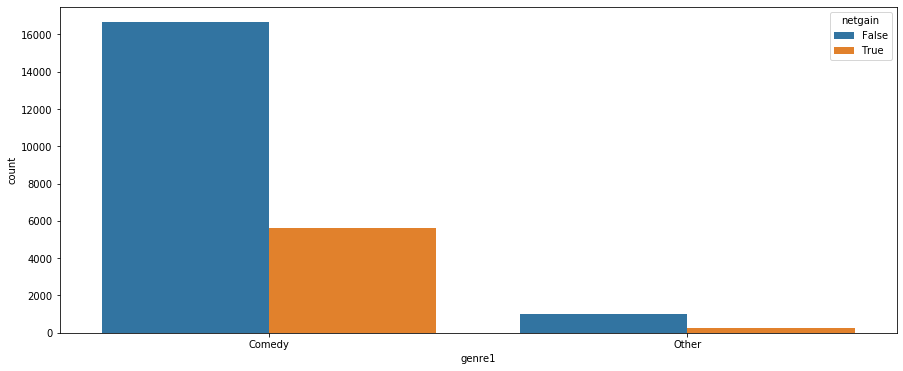

In [286]:
f = plt.figure(figsize=(15,6))
sns.countplot(x='genre1',hue='netgain',data=data)

In [287]:
data['airlocation'].value_counts()

United-States                 23250
Mexico                          523
International                   465
Philippines                     141
Germany                         114
Canada                           94
Cuba                             86
Puerto-Rico                      85
El-Salvador                      84
India                            81
England                          79
Italy                            70
South                            69
Poland                           66
Jamaica                          63
Dominican-Republic               62
Guatemala                        61
Vietnam                          57
Columbia                         55
Japan                            54
China                            53
Taiwan                           37
Iran                             36
Haiti                            35
Ecuador                          31
Portugal                         30
Peru                             28
Nicaragua                   

In [288]:
#df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
data['airloc'] = data['airlocation'].apply(lambda x: 'US' if x== 'United-States' else 'other')

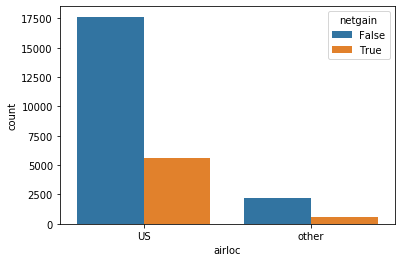

In [289]:
sns.countplot('airloc',hue = 'netgain',data=data)

In [290]:
data.pivot_table(index=['airloc'],columns='netgain',aggfunc={'netgain':'count'})

netgain      
netgain   False True 
airloc               
US        17645  5605
other      2208   590

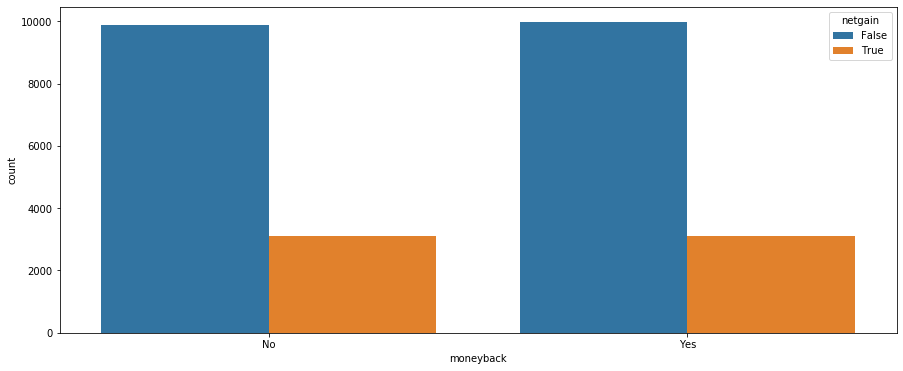

In [291]:
f = plt.figure(figsize=(15,6))
sns.countplot(x='moneyback',hue='netgain',data=data)

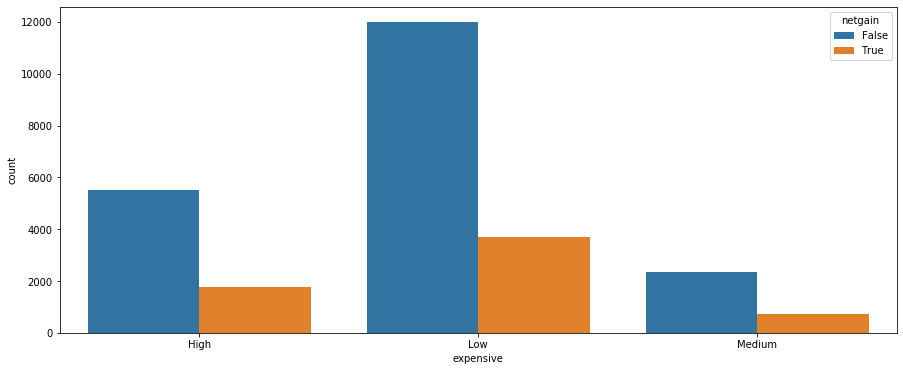

In [292]:
f = plt.figure(figsize=(15,6))
sns.countplot(x='expensive',hue='netgain',data=data)

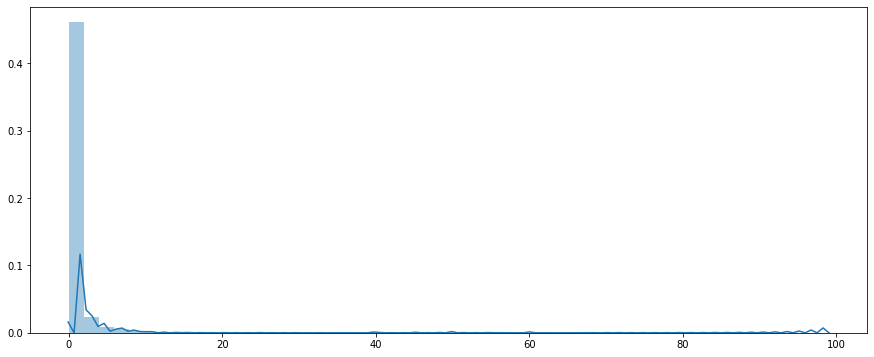

In [293]:
f = plt.figure(figsize=(15,6))
sns.distplot(data['ratings']*data['avg_runt'])

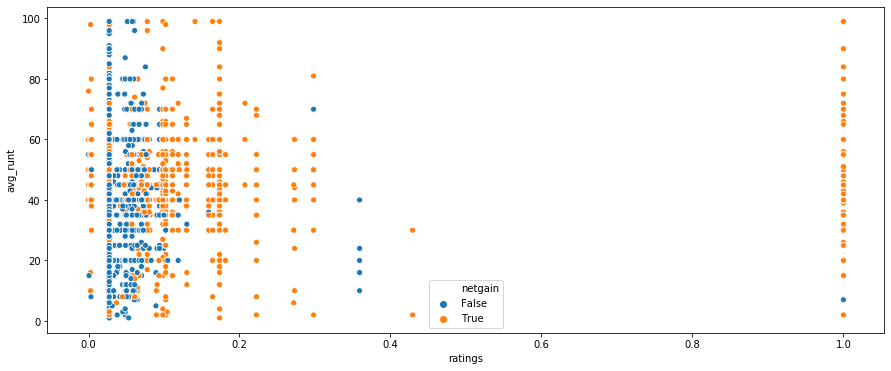

In [294]:
f = plt.figure(figsize=(15,6))
sns.scatterplot(x='ratings',y='avg_runt',hue='netgain',data=data)

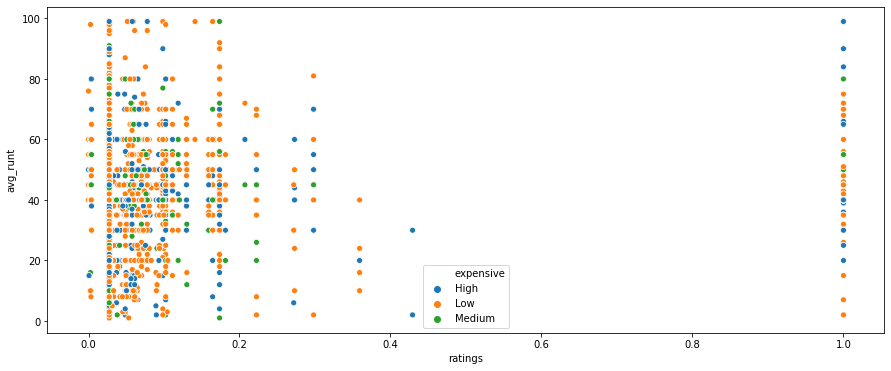

In [295]:
f = plt.figure(figsize=(15,6))
sns.scatterplot(x='ratings',y='avg_runt',hue='expensive',data=data)

In [296]:
data['netgain'] = [1 if x==True else 0 for x in data['netgain']]

In [297]:
data.head()

,id,rs,industry,genre,sex,avg_runt,airtime,airlocation,ratings,expensive,moneyback,netgain,rs1,genre1,airloc
0,19717,Married-spouse-absent,Auto,Comedy,Male,45,Primetime,United-States,0.027465,High,No,0,Married,Comedy,US
1,31593,Married-civ-spouse,Pharma,Comedy,Male,45,Primetime,United-States,0.027465,Low,No,0,Married,Comedy,US
2,5681,Divorced,Entertainment,Comedy,Female,45,Primetime,United-States,0.027465,High,Yes,0,Other,Comedy,US
3,15491,Separated,Political,Infomercial,Female,40,Primetime,United-States,0.027465,Low,No,0,Other,NaN,US
4,23587,Married-civ-spouse,Pharma,Comedy,Male,48,Primetime,United-States,0.027465,High,No,1,Married,Comedy,US


#### Encoding categorical Variables

In [298]:
rs1 = pd.get_dummies(data['rs1'], prefix='rs_',drop_first=True)

In [299]:
ind = pd.get_dummies(data['industry'], prefix='ind_',drop_first=True)

In [300]:
genre1 = pd.get_dummies(data['genre1'], prefix='genre_',drop_first=True)

In [301]:
sex = pd.get_dummies(data['sex'], prefix='sex_',drop_first=True)

In [302]:
airloc = pd.get_dummies(data['airloc'], prefix='airloc_',drop_first=True)

In [303]:
airtime = pd.get_dummies(data['airtime'], prefix='airtime_',drop_first=True)

In [304]:
expensive = pd.get_dummies(data['expensive'], prefix='expensive_',drop_first=True)

In [305]:
new = data[['avg_runt','ratings','netgain']]

In [306]:
new =pd.concat([new,rs1,ind,genre1, sex,airloc,airtime,expensive],axis=1)

In [307]:
new.head()

,avg_runt,ratings,netgain,rs__Other,ind__ClassAction,ind__Entertainment,ind__Other,ind__Pharma,ind__Political,genre__Other,sex__Male,airloc__other,airtime__Morning,airtime__Primetime,expensive__Low,expensive__Medium
0,45,0.027465,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,45,0.027465,0,0,0,0,0,1,0,0,1,0,0,1,1,0
2,45,0.027465,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,40,0.027465,0,1,0,0,0,0,1,0,0,0,0,1,1,0
4,48,0.027465,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [308]:
train= new

#### Data Preprocessing function :
Preprocess test data

In [309]:
def preprocessing(data):
    data = data.rename(columns={"realtionship_status": "rs", "targeted_sex": "sex",'average_runtime(minutes_per_week)':'avg_runt','money_back_guarantee':'moneyback'})
    data['genre1'] = data['genre'].map({'Direct':'Other','Drama':'Other','Comedy':'Comedy','Infomerical':'Infomerical','Other':'Other'})
    data['rs1']=data['rs'].map({'Married-spouse-absent':'Married', 'Married-civ-spouse':'Married', 'Divorced':'Other','Separated':'Other', 'Never-married':'Other', 'Widowed':'Other', 'Married-AF-spouse':'Married'})
    data['airloc'] = data['airlocation'].apply(lambda x: 'US' if x== 'United-States' else 'other')
    
    rs1 = pd.get_dummies(data['rs1'], prefix='rs_',drop_first=True)
    ind = pd.get_dummies(data['industry'], prefix='ind_',drop_first=True)
    genre1 = pd.get_dummies(data['genre1'], prefix='genre_',drop_first=True)
    sex = pd.get_dummies(data['sex'], prefix='sex_',drop_first=True)
    airloc = pd.get_dummies(data['airloc'], prefix='airloc_',drop_first=True)
    airtime = pd.get_dummies(data['airtime'], prefix='airtime_',drop_first=True)
    expensive = pd.get_dummies(data['expensive'], prefix='expensive_',drop_first=True)
    new = data[['avg_runt','ratings']]
    new =pd.concat([new,rs1,ind,genre1, sex,airloc,airtime,expensive],axis=1)
#     scaler = StandardScaler().fit(new)
#     new = scaler.transform(new)
    return new

In [310]:
test = pd.read_csv('Test.csv')

In [311]:
test = preprocessing(test)

In [312]:
train.head()

,avg_runt,ratings,netgain,rs__Other,ind__ClassAction,ind__Entertainment,ind__Other,ind__Pharma,ind__Political,genre__Other,sex__Male,airloc__other,airtime__Morning,airtime__Primetime,expensive__Low,expensive__Medium
0,45,0.027465,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,45,0.027465,0,0,0,0,0,1,0,0,1,0,0,1,1,0
2,45,0.027465,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,40,0.027465,0,1,0,0,0,0,1,0,0,0,0,1,1,0
4,48,0.027465,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [313]:
test.head()

,avg_runt,ratings,rs__Other,ind__ClassAction,ind__Entertainment,ind__Other,ind__Pharma,ind__Political,genre__Other,sex__Male,airloc__other,airtime__Morning,airtime__Primetime,expensive__Low,expensive__Medium
0,10,0.027465,1,0,0,0,0,0,0,0,0,0,0,1,0
1,40,0.056262,0,0,0,0,1,0,0,1,0,1,0,0,0
2,50,0.027465,1,0,1,0,0,0,0,0,0,1,0,1,0
3,40,0.027465,0,0,0,0,1,0,0,1,0,0,1,1,0
4,40,0.027465,0,0,0,0,1,0,0,1,0,0,1,1,0


In [314]:
y_train = train['netgain']
X_train = train.drop(columns='netgain')

#### Working on ensemble stacking with base models as :KNN, Random Forest, XGBClassifier, DecisionTree

In [315]:
models = [
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=101, n_jobs=-1, 
                           n_estimators=500, max_depth=7),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.05, 
                  n_estimators=500, max_depth=3),
  
    DecisionTreeClassifier(random_state=101)
    
]

In [318]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.76813820]
    fold  1:  [0.78445298]
    fold  2:  [0.76737044]
    fold  3:  [0.76713381]
    fold  4:  [0.78594740]
    ----
    MEAN:     [0.77460856] + [0.00866729]
    FULL:     [0.77460842]

model  1:     [RandomForestClassifier]
    fold  0:  [0.81151631]
    fold  1:  [0.81880998]
    fold  2:  [0.81785029]
    fold  3:  [0.81148013]
    fold  4:  [0.81128816]
    ----
    MEAN:     [0.81418897] + [0.00339572]
    FULL:     [0.81418919]

model  2:     [XGBClassifier]
    fold  0:  [0.81976967]
    fold  1:  [0.82130518]
    fold  2:  [0.82034549]
    fold  3:  [0.81493569]
    fold  4:  [0.81666347]
    ----
    MEAN:     [0.81860390] + [0.00240459]
    FULL:     [0.81860412]

model  3:     [DecisionTreeClassifier]
    fold  0:  [0.80460653]
    fold  1:  [0.80825336]
    fold  2:  [0.80403071]
    

In [319]:
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.05, 
                      n_estimators=500, max_depth=3)
    
model = model.fit(S_train, y_train)
predictions = model.predict(S_test)

In [320]:
test1 = pd.read_csv('Test.csv')
idc = test1['id']

In [321]:
StackingSubmission = pd.DataFrame({ 'id': idc,
                            'netgain': predictions })

In [322]:
StackingSubmission['netgain'] = StackingSubmission['netgain'].apply(lambda x: 'TRUE' if x==1 else 'FALSE')

In [324]:
StackingSubmission.to_csv("Submission_Final.csv", index=False)